In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
all_data=[]
paths =[r'spam_data/spam_data/spam', r'spam_data/spam_data/easy_ham', r'spam_data/spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)

In [3]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [4]:
X

array(["Save $100's, maybe $1,000's with No Lender's Fees. Click here!",
       'Behind Every Elite Producer...', '[]  ߴ  Best 5 & ڰ  ǳ', ...,
       'THE WEEK IN REVIEW: Harvest at Macworld',
       'GAMESPOT PC: Lionheart designer diary, No One Lives Forever 2 screenshot update, and more!',
       "Subject: There's still time to enter Lifetime's New Season Sweeps!"],
      dtype='<U109')

In [5]:
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [6]:
all_data

array([["Save $100's, maybe $1,000's with No Lender's Fees. Click here!",
        '1'],
       ['Behind Every Elite Producer...', '1'],
       ['[]  ߴ  Best 5 & ڰ  ǳ', '1'],
       ...,
       ['THE WEEK IN REVIEW: Harvest at Macworld', '0'],
       ['GAMESPOT PC: Lionheart designer diary, No One Lives Forever 2 screenshot update, and more!',
        '0'],
       ["Subject: There's still time to enter Lifetime's New Season Sweeps!",
        '0']], dtype='<U109')

In [7]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
                 

[nltk_data] Downloading package stopwords to /home/eating/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
X = clean_content(X)

In [9]:
X

['save maybe lender fee click',
 'behind every elite producer',
 'best',
 'faery',
 'business owner friendly pension plan',
 'plan family future zbm',
 'pru life ul portfolio rock',
 'one sale three commission stream',
 'slim factor totally new approach weight loss',
 'online catalog article adult toy vjtt dml',
 'tell cam slut',
 'new version uncover truth anyone',
 'fwd direct marketing work',
 'attn pound lighter olibykn',
 'online doctor fill viagra prescription qeeb',
 'work home month',
 'need urgent capable assistance tel',
 'join get dvd ea shipping processing detail inside',
 'new insurance product competition',
 'per year possible net illegal mlm junk time pm',
 'earn one year work home',
 'tell send health card',
 'wan na see get fisted',
 'warn computer may contain virus',
 'adv low life insurance rate available hsdpr',
 'private label reseller host expires',
 'make fortune ebay',
 'systemworks clearance sale sqj',
 'commission high publish',
 'one kind money maker try free

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

In [11]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [12]:
x_train.shape

(2738, 1500)

In [13]:
np.unique(y_train)

array([0, 1], dtype=uint8)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/eating/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [16]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  

In [17]:
model = Model(input_dimention=1500,output_classes=2).to(device)

In [18]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 1500])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])


In [19]:
batch_size = 4
input_features = 1500
dummy_input = torch.randn(batch_size, input_features).to(device)

In [20]:
output = model(dummy_input)
print(output)

tensor([[-0.2392,  0.9755],
        [ 0.1044, -0.0947],
        [ 0.0784,  0.5568],
        [-1.1158,  0.1950]], grad_fn=<AddmmBackward>)


In [21]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss
import torch.optim as optim

criterion = CrossEntropyLoss()

In [22]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [23]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [24]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

In [25]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))

epoch : 0
目前 train loss : 0.44
目前 test loss : 0.38
目前 test accuracy : 0.86
epoch : 2
目前 train loss : 0.29
目前 test loss : 0.25
目前 test accuracy : 0.91
epoch : 4
目前 train loss : 0.24
目前 test loss : 0.23
目前 test accuracy : 0.92
epoch : 6
目前 train loss : 0.23
目前 test loss : 0.22
目前 test accuracy : 0.92
epoch : 8
目前 train loss : 0.20
目前 test loss : 0.23
目前 test accuracy : 0.91
epoch : 10
目前 train loss : 0.19
目前 test loss : 0.23
目前 test accuracy : 0.93
epoch : 12
目前 train loss : 0.18
目前 test loss : 0.25
目前 test accuracy : 0.91
epoch : 14
目前 train loss : 0.18
目前 test loss : 0.24
目前 test accuracy : 0.92
epoch : 16
目前 train loss : 0.18
目前 test loss : 0.24
目前 test accuracy : 0.92
epoch : 18
目前 train loss : 0.17
目前 test loss : 0.26
目前 test accuracy : 0.92
epoch : 20
目前 train loss : 0.18
目前 test loss : 0.24
目前 test accuracy : 0.92
epoch : 22
目前 train loss : 0.18
目前 test loss : 0.25
目前 test accuracy : 0.92
epoch : 24
目前 train loss : 0.16
目前 test loss : 0.27
目前 test accuracy : 0.92
epoch : 26
目前 tra

In [26]:
print(classification_report(prediction, y_test_numpy))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       565
           1       0.78      0.63      0.70       120

    accuracy                           0.90       685
   macro avg       0.85      0.80      0.82       685
weighted avg       0.90      0.90      0.90       685



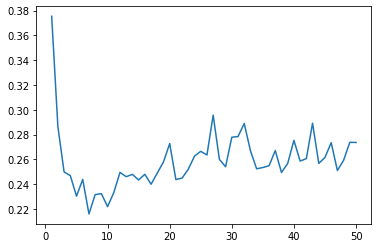

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

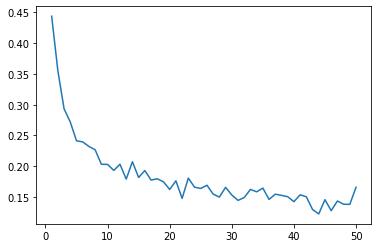

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

In [29]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './eating_model_save.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)

In [30]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content=cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
